In [1]:
import json
import pandas as pd
import numpy as np
from noggin import create_plot
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cuda', index=0)

In [5]:
file_path1 = r"Sarcasm_Headlines_Dataset.json"
df = pd.read_json(file_path1,lines=True)
df = df[['headline','is_sarcastic']]
#print(df[:50])

In [6]:
df

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0
...,...,...
26704,american politics in moral free-fall,0
26705,america's best 20 hikes,0
26706,reparations and obama,0
26707,israeli ban targeting boycott supporters raise...,0


In [7]:
x = np.asarray(df)

In [8]:
x.shape

(26709, 2)

In [9]:
x[:,1]

array([0, 0, 1, ..., 0, 0, 0], dtype=object)

In [10]:
import random
import numpy as np

def train_split(data, validation=0.2):
    N = len(data)
    print(N)
    breakpoint = int(validation*N)
    
    data_idxs = list(np.arange(N))
    
    random.shuffle(data_idxs)
    #print(data_idxs)
    
    return data[data_idxs[:breakpoint], :], data[data_idxs[breakpoint:], :]

In [11]:
testing_data, training_data = train_split(x)

26709


In [12]:
testing_data.shape
testing_data

array([['liberal male hypocrisy, modern day rasputins and the culture of deceit',
        0],
       ['why progressives are cautiously optimistic about hillary clinton',
        0],
       ["fugitive caretakers allegedly steal wwii veteran's life savings",
        0],
       ...,
       ['how the wicked wanderlust can ruin your life', 0],
       ['after dark: meet joey arias, drag icon and nightlife legend', 0],
       ["kate hudson's matthew mcconaughey impression is spot on", 0]],
      dtype=object)

In [13]:
training_data

array([["cnn technicians rush to empty wolf blitzer's urine tank midway through election coverage",
        1],
       ["monopoly releases special 'regular monopoly' edition", 1],
       ['gourmet gifts for the foodie 2014', 0],
       ...,
       ['justice stevens retires to spend more time dying in front of family',
        1],
       ['report: it still nowhere near okay to act like donald trump', 1],
       ['jessica simpson reveals slimmer figure after chopping off limbs',
        1]], dtype=object)

In [14]:
training_data.shape

(21368, 2)

In [15]:
#tokenizer stuff
from torchtext.data import get_tokenizer
tokenizer = get_tokenizer("basic_english")

def tokenize(data):
    tokens = [tokenizer(headline) for headline in data[:, 0]]
    return tokens

In [16]:
tokenizedTrainingData = tokenize(training_data)
tokenizedTestingData = tokenize(testing_data)

In [17]:
tokenizedTrainingData

[['cnn',
  'technicians',
  'rush',
  'to',
  'empty',
  'wolf',
  'blitzer',
  "'",
  's',
  'urine',
  'tank',
  'midway',
  'through',
  'election',
  'coverage'],
 ['monopoly',
  'releases',
  'special',
  "'",
  'regular',
  'monopoly',
  "'",
  'edition'],
 ['gourmet', 'gifts', 'for', 'the', 'foodie', '2014'],
 ['ganymede', 'totalled', 'in', 'three-moon', 'pileup'],
 ['last',
  'dog',
  'at',
  'the',
  'shelter',
  'receives',
  'the',
  'sweetest',
  'farewell',
  'party'],
 ['what', 'being', "'", 'pro-israel', "'", 'should', 'mean'],
 ['trump',
  "'",
  's',
  'jerusalem',
  'embassy',
  'ceremony',
  'was',
  'one',
  'big',
  'dog',
  'whistle'],
 ['3822', 'voted', 'america', "'", 's', 'favorite', 'pin', 'number'],
 ['feeling',
  'overwhelmed',
  'by',
  'all',
  'the',
  'news',
  'this',
  'year',
  '?',
  'you',
  "'",
  're',
  'in',
  'the',
  'minority',
  '.'],
 ["'",
  'no',
  'way',
  'to',
  'prevent',
  'this',
  ',',
  "'",
  'says',
  'only',
  'nation',
  'wher

In [18]:
trainingVocab = torchtext.vocab.build_vocab_from_iterator(tokenizedTrainingData)

In [19]:
vocabArr = np.array([word for word in trainingVocab.get_stoi().keys()])

In [20]:
len(vocabArr)

24961

In [21]:
class Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout, pad_idx):
        super().__init__()
#         self.embed = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        self.LSTM = nn.LSTM(embedding_dim,
                            hidden_dim, 
                            num_layers = n_layers, 
                            dropout = dropout, 
                            bidirectional = True, 
                            batch_first = True)
        self.Linear = nn.Linear(hidden_dim*2, output_dim)
#         self.Dropout = nn.dropout(dropout = dropout)
        
    def forward(self, text, text_length):
#         embedding = self.embed(text)
        
        packedEmbeddings = torch.nn.utils.rnn.pack_padded_sequence(text, text_length, batch_first = True)   
        packedOutput, (hidden, cell) = self.LSTM(packedEmbeddings)
#         unpackedOutput, unpackedLength = torch.nn.utils.rnn.pad_packed_sequence(packedOutput)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        return self.Linear(hidden)
 

In [22]:
vocab_size = len(vocabArr)
embedding_dim = 100 # was 200
hidden_dim = 256 #was 10
output_dim = 1
n_layers = 2
dropout = 0.5
pad_idx = 0 #change

model = Model(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout, pad_idx).to(device)

In [23]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    return correct.sum() / len(correct)


In [24]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters()) 

In [25]:
sigmoidBCE = nn.BCEWithLogitsLoss()

C:\Users\evan_\.conda\envs\week4\lib\site-packages\noggin\plotter.py:364: UserWarning: Live plotting is not supported when matplotlib uses the 'module://matplotlib_inline.backend_inline'
backend. Instead, use the 'nbAgg' backend.

In a Jupyter notebook, this can be activated using the cell magic:
   %matplotlib notebook.
  warn(cleandoc(_inline_msg.format(self._backend)))


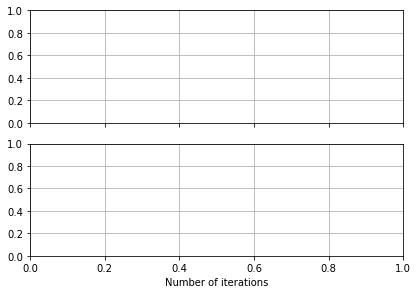

In [26]:
plotter, fig, ax = create_plot(["loss", "accuracy"])


In [27]:
training_data

array([["cnn technicians rush to empty wolf blitzer's urine tank midway through election coverage",
        1],
       ["monopoly releases special 'regular monopoly' edition", 1],
       ['gourmet gifts for the foodie 2014', 0],
       ...,
       ['justice stevens retires to spend more time dying in front of family',
        1],
       ['report: it still nowhere near okay to act like donald trump', 1],
       ['jessica simpson reveals slimmer figure after chopping off limbs',
        1]], dtype=object)

In [28]:
vec = torchtext.vocab.GloVe(name = '6B', dim = 100)

In [29]:
trainingEmbeddings = [vec.get_vecs_by_tokens(sentence).tolist() for sentence in tokenizedTrainingData]
testingEmbeddings = [vec.get_vecs_by_tokens(sentence).tolist() for sentence in tokenizedTestingData]


In [30]:
trainingEmbeddings[0:5]

[[[-0.5007200241088867,
   -0.5416300296783447,
   0.2551099956035614,
   -0.6958500146865845,
   0.11068999767303467,
   -0.2358199954032898,
   0.47407999634742737,
   0.4911400079727173,
   0.5667499899864197,
   -0.08777400106191635,
   0.6022199988365173,
   0.02259499952197075,
   0.1262200027704239,
   -0.5652499794960022,
   0.11283999681472778,
   -0.44885000586509705,
   -0.222120001912117,
   -0.8397700190544128,
   -0.39473000168800354,
   -0.10497000068426132,
   -0.3718000054359436,
   0.4093100130558014,
   -0.1988299936056137,
   0.22651000320911407,
   0.6618499755859375,
   -0.2287999987602234,
   0.8668000102043152,
   0.964900016784668,
   0.25554999709129333,
   0.5453500151634216,
   0.9468700289726257,
   0.8115699887275696,
   -0.38113000988960266,
   0.7346400022506714,
   -0.10795000195503235,
   0.733739972114563,
   0.16779999434947968,
   0.3824799954891205,
   0.2965199947357178,
   0.5271400213241577,
   -0.6982499957084656,
   0.6398199796676636,
   -0.6

In [31]:
training_max_length = max(len(sentence) for sentence in trainingEmbeddings)
testing_max_length = max(len(sentence) for sentence in testingEmbeddings)

max_length = max(training_max_length, testing_max_length)

training_padded = np.zeros((len(trainingEmbeddings), max_length, 100))

for sentence_idx in range(len(trainingEmbeddings)):
    sentence = trainingEmbeddings[sentence_idx]
    for word_idx in range(len(trainingEmbeddings[sentence_idx])):
        word = sentence[word_idx]
        training_padded[sentence_idx][word_idx] = word


In [32]:
testing_padded = np.zeros((len(testingEmbeddings), max_length, 100))

for sentence_idx in range(len(testingEmbeddings)):
    sentence = testingEmbeddings[sentence_idx]
    for word_idx in range(len(testingEmbeddings[sentence_idx])):
        word = sentence[word_idx]
        testing_padded[sentence_idx][word_idx] = word

In [43]:
num_epochs = 10
batch_size = 100

criterion = nn.CrossEntropyLoss()
# print(training_data.shape)
for epoch in range(num_epochs):
    print(epoch)
    idxs = np.arange(len(training_data))  # -> array([0, 1, ..., num_train-1])
    np.random.shuffle(idxs)  # shuffles indices in-place
    
    for batch_cnt in range(len(training_data) // batch_size):
        batch_indices = idxs[batch_cnt * batch_size : (batch_cnt + 1) * batch_size]
#         print(training_data.shape)
#         print(training_data[batch_indices])
        batch = training_padded[batch_indices]  # <COGSTUB> get the random batch of our training data
        truth = training_data[batch_indices][:, 1] # <COGSTUB> get the true labels for this batch of images
        truth = np.vstack(truth).astype(np.int)

#         print(batch)
#         truth = np.reshape(truth, (100, 1))
#         print(truth.shape)
        text_lengths = [len(sentence) for sentence in batch]
        training_paddedArr = torch.from_numpy(training_padded)
        b = torch.tensor(batch, dtype = torch.float32, device=device)
#         t = torch.tensor(text_lengths, dtype = torch.long, device=torch.device('cpu'))
#         print("btype:",b.type())
#         print("ttype:",t.type())
        t = text_lengths
        prediction = model(b,t)
#         prediction = torch.reshape(prediction, (100,))
        
        
#         print(prediction.shape)
#         print(prediction)
#         print(truth.shape)
#         print(type(truth[0]))
    
        
#         loss = sigmoidBCE(prediction, torch.from_numpy(truth).to(device))
        loss = criterion(prediction, torch.tensor(truth, dtype=torch.float, device=device))
        print("Training Loss: ", loss.item())

        loss.backward()
        optimizer.step()
        acc = binary_accuracy(prediction, torch.tensor(truth, dtype = torch.float32, device=device))
        print("Training accuracy: ", acc.item())

        plotter.set_train_batch(
            {"loss": loss.item(), "accuracy": acc.item()}, batch_size=batch_size
        )
    
      # Here, we evaluate our model on batches of *testing* data
    # this will show us how good our model does on data that
    # it has never encountered
    # Iterate over batches of *testing* data
    for batch_cnt in range(0, len(testing_data) // batch_size):
        idxs = np.arange(len(testing_data))
        batch_indices = idxs[batch_cnt * batch_size : (batch_cnt + 1) * batch_size]  # <COGSTUB>  get the batch of our **test** data
        batch = testing_padded[batch_indices]  # <COGSTUB>  get the batch of our **test** labels

        with torch.no_grad():
            # get your model's prediction on the test-batch
            text_lengths = [len(sentence) for sentence in batch]
            
            b = torch.tensor(batch, dtype = torch.float32, device=device)
#             t = torch.tensor(text_lengths, dtype = torch.torch.long, device=torch.device('cpu'))
            t = text_lengths
            prediction = model(b,t)

            # get the truth values for that test-batch
            truth = training_data[batch_indices][:, 1] # <COGSTUB> get the true labels for this batch of images
            truth = np.vstack(truth).astype(np.int)

            # compute the test accuracy
            acc = binary_accuracy(prediction, torch.tensor(truth, dtype = torch.float32, device=device))
            print("Validation accuracy: ", acc.item())

        # log the test-accuracy in noggin
        plotter.set_test_batch({"accuracy": acc.item()}, batch_size=batch_size)

    plotter.set_train_epoch()
    plotter.set_test_epoch()
plotter.plot()    

0
Training Loss:  -0.0
Training accuracy:  0.4399999976158142
Training Loss:  -0.0
Training accuracy:  0.5099999904632568
Training Loss:  -0.0
Training accuracy:  0.5299999713897705
Training Loss:  -0.0
Training accuracy:  0.6100000143051147
Training Loss:  -0.0
Training accuracy:  0.5999999642372131
Training Loss:  -0.0
Training accuracy:  0.5899999737739563
Training Loss:  -0.0
Training accuracy:  0.5099999904632568


C:\Users\evan_\AppData\Local\Temp\ipykernel_31444\4015327069.py:17: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  truth = np.vstack(truth).astype(np.int)


Training Loss:  -0.0
Training accuracy:  0.5899999737739563
Training Loss:  -0.0
Training accuracy:  0.4399999976158142
Training Loss:  -0.0
Training accuracy:  0.5399999618530273
Training Loss:  -0.0
Training accuracy:  0.5399999618530273
Training Loss:  -0.0
Training accuracy:  0.5
Training Loss:  -0.0
Training accuracy:  0.4699999988079071
Training Loss:  -0.0
Training accuracy:  0.5899999737739563
Training Loss:  -0.0
Training accuracy:  0.5699999928474426
Training Loss:  -0.0
Training accuracy:  0.5299999713897705
Training Loss:  -0.0
Training accuracy:  0.5099999904632568
Training Loss:  -0.0
Training accuracy:  0.5099999904632568
Training Loss:  -0.0
Training accuracy:  0.5699999928474426
Training Loss:  -0.0
Training accuracy:  0.4399999976158142
Training Loss:  -0.0
Training accuracy:  0.4699999988079071
Training Loss:  -0.0
Training accuracy:  0.550000011920929
Training Loss:  -0.0
Training accuracy:  0.5999999642372131
Training Loss:  -0.0
Training accuracy:  0.5999999642372

Training Loss:  -0.0
Training accuracy:  0.5199999809265137
Training Loss:  -0.0
Training accuracy:  0.5799999833106995
Training Loss:  -0.0
Training accuracy:  0.5199999809265137
Training Loss:  -0.0
Training accuracy:  0.5299999713897705
Training Loss:  -0.0
Training accuracy:  0.4899999797344208
Training Loss:  -0.0
Training accuracy:  0.5
Training Loss:  -0.0
Training accuracy:  0.5399999618530273
Training Loss:  -0.0
Training accuracy:  0.4899999797344208
Training Loss:  -0.0
Training accuracy:  0.47999998927116394
Training Loss:  -0.0
Training accuracy:  0.5799999833106995
Training Loss:  -0.0
Training accuracy:  0.47999998927116394
Training Loss:  -0.0
Training accuracy:  0.5099999904632568
Training Loss:  -0.0
Training accuracy:  0.5299999713897705
Training Loss:  -0.0
Training accuracy:  0.4699999988079071
Training Loss:  -0.0
Training accuracy:  0.5899999737739563
Training Loss:  -0.0
Training accuracy:  0.44999998807907104
Training Loss:  -0.0
Training accuracy:  0.529999971

C:\Users\evan_\AppData\Local\Temp\ipykernel_31444\4015327069.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  truth = np.vstack(truth).astype(np.int)


TypeError: can only concatenate str (not "float") to str